## Load libraries

In [1]:
# tensorflow backend
print('tensorflow backend')
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
print('vae stuff')
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
print('iport scientific py')
import numpy as np
import pandas as pd
# rdkit stuff
print('rdkit stuff')
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
print('plotting stuff')
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import numpy as np 

import pandas as pd

tensorflow backend
vae stuff


Using TensorFlow backend.
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packag

iport scientific py
rdkit stuff
plotting stuff


## Load a model

In [3]:
vae = VAEUtils(directory='models/zinc_properties')

From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From C:\Users\PC\.conda\envs\01_chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1156: calling reduce_max (from tensorflow.python.ops.mat

Using standarized functions? True
Standarization: estimating mu and std values ...done!


## Load smiles

In [3]:

smiles_group = []
df = pd.read_csv('./data/mao/mao_smiles.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
smiles_group = (df.columns.values.tolist() + df.values.tolist())[2:]

df = pd.read_csv('./data/mao/asinex_smiles.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
smiles_group.extend((df.columns.values.tolist() + df.values.tolist())[2:])
print('molcule fetched :', len(smiles_group))

molcule fetched : 138917


## Decode latent space / fingerprint

In [5]:
# bytes to bits
def access_bit(data, num):
    base = int(num // 8)
    shift = int(num % 8)
    return (data[base] & (1<<shift)) >> shift

def smiles_to_vect(smiles_group):
    print('# of smiles group:', len(smiles_group))
    
    print('canonizing smiles...')
    smiles_list = [ mu.canon_smiles(data[0]) for data in smiles_group ]
    
    print('encoding mols to hot...')
    Xs = []
    count = 0
    for idx, smiles in enumerate(smiles_list):
        try:
            Xs.append(vae.smiles_to_hot(smiles, canonize_smiles=True))
        except:
            count += 1
            del smiles_group[idx]
    print('failed:', count)
    print('# of smiles group:', len(smiles_group))

    print('encoding mols...')
    Zs = []
    count = 0
    for idx, X in enumerate(Xs):
        try:
            Zs.append(list(vae.encode(X)[0]))
        except:
            count += 1
            del smiles_group[idx]
    print('failed:', count)
    print('# of smiles group:', len(smiles_group))
    
    latent_group.extend(list(zip(Zs, [ data[1] for data in smiles_group ])))
    
    mols = [ Chem.MolFromSmiles(smiles) for smiles in smiles_list ]

## Convert smiles to coordinates

In [6]:
latent_group = []
smiles_to_vect(smiles_group)

# of smiles group: 138917
canonizing smiles...
encoding mols to hot...
failed: 203
# of smiles group: 138714
encoding mols...
failed: 85
# of smiles group: 138629


## Save latent data

In [12]:
df = pd.DataFrame(latent_group)
df.to_csv('./data/mao/latent_group.csv')

## Load latent data

In [46]:
print('fetching latent space group...')
latent_group = []
df = pd.read_csv('./data/mao/latent_group.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
for i in range(len(df)):
    points = list(map(float, df.loc[i, '0'].strip('[]').split(', ')))
    latent_group.append([points, df.loc[i, '1']])
print('# of fetched data:', len(latent_group))

fetching latent space group...
# of fetched data: 138629


## Build DimReduction Model

In [44]:
n_components = 2
model_pca = PCA(n_components=n_components)
model_tsne = TSNE(n_components=n_components)

## Train and Save DimReduction Model

In [47]:
print('\r(1/2) {:30s}'.format('training latent pca...'))
points_latent_pca = model_pca.fit_transform([ points[0] for points in latent_group ])
df = pd.DataFrame(points_latent_pca)
df.to_csv('./data/mao/points_latent_pca.csv')

print('\r(2/2) {:30s}'.format('training latent tsne...'))
points_latent_tsne = model_tsne.fit_transform([ points[0] for points in latent_group ])
df = pd.DataFrame(points_latent_tsne)
df.to_csv('./data/mao/points_latent_tsne.csv')


(2/2) training latent tsne...       


## Load coordinates

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [8]:
print('(0/2) fetching latent space group...')
latent_target_group = []
df = pd.read_csv('./data/mao/latent_group.csv')
latent_target_group = df['1'].values.tolist()
print('data fetched:', len(latent_target_group))

print('(1/2) fetching latent space tsne points...')
points_latent_tsne = []
df = pd.read_csv('./data/mao/points_latent_tsne.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_latent_tsne = df.values.tolist()
print('data fetched:', len(points_latent_tsne))

print('(2/2) fetching latent space pca points...')
points_latent_pca = []
df = pd.read_csv('./data/mao/points_latent_pca.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
points_latent_pca = df.values.tolist()
print('data fetched:', len(points_latent_pca))

# sort loaded data
sorted = list(zip(latent_target_group, points_latent_pca, points_latent_tsne))
sorted.sort(key=lambda x:x[0])
latent_target_group = list(np.array(sorted, dtype=object).T[0])
points_latent_pca = list(np.array(sorted, dtype=object).T[1])
points_latent_tsne = list(np.array(sorted, dtype=object).T[2])

(0/2) fetching latent space group...
data fetched: 138629
(1/2) fetching latent space tsne points...
data fetched: 138629
(2/2) fetching latent space pca points...
data fetched: 138629


## Visualize the data

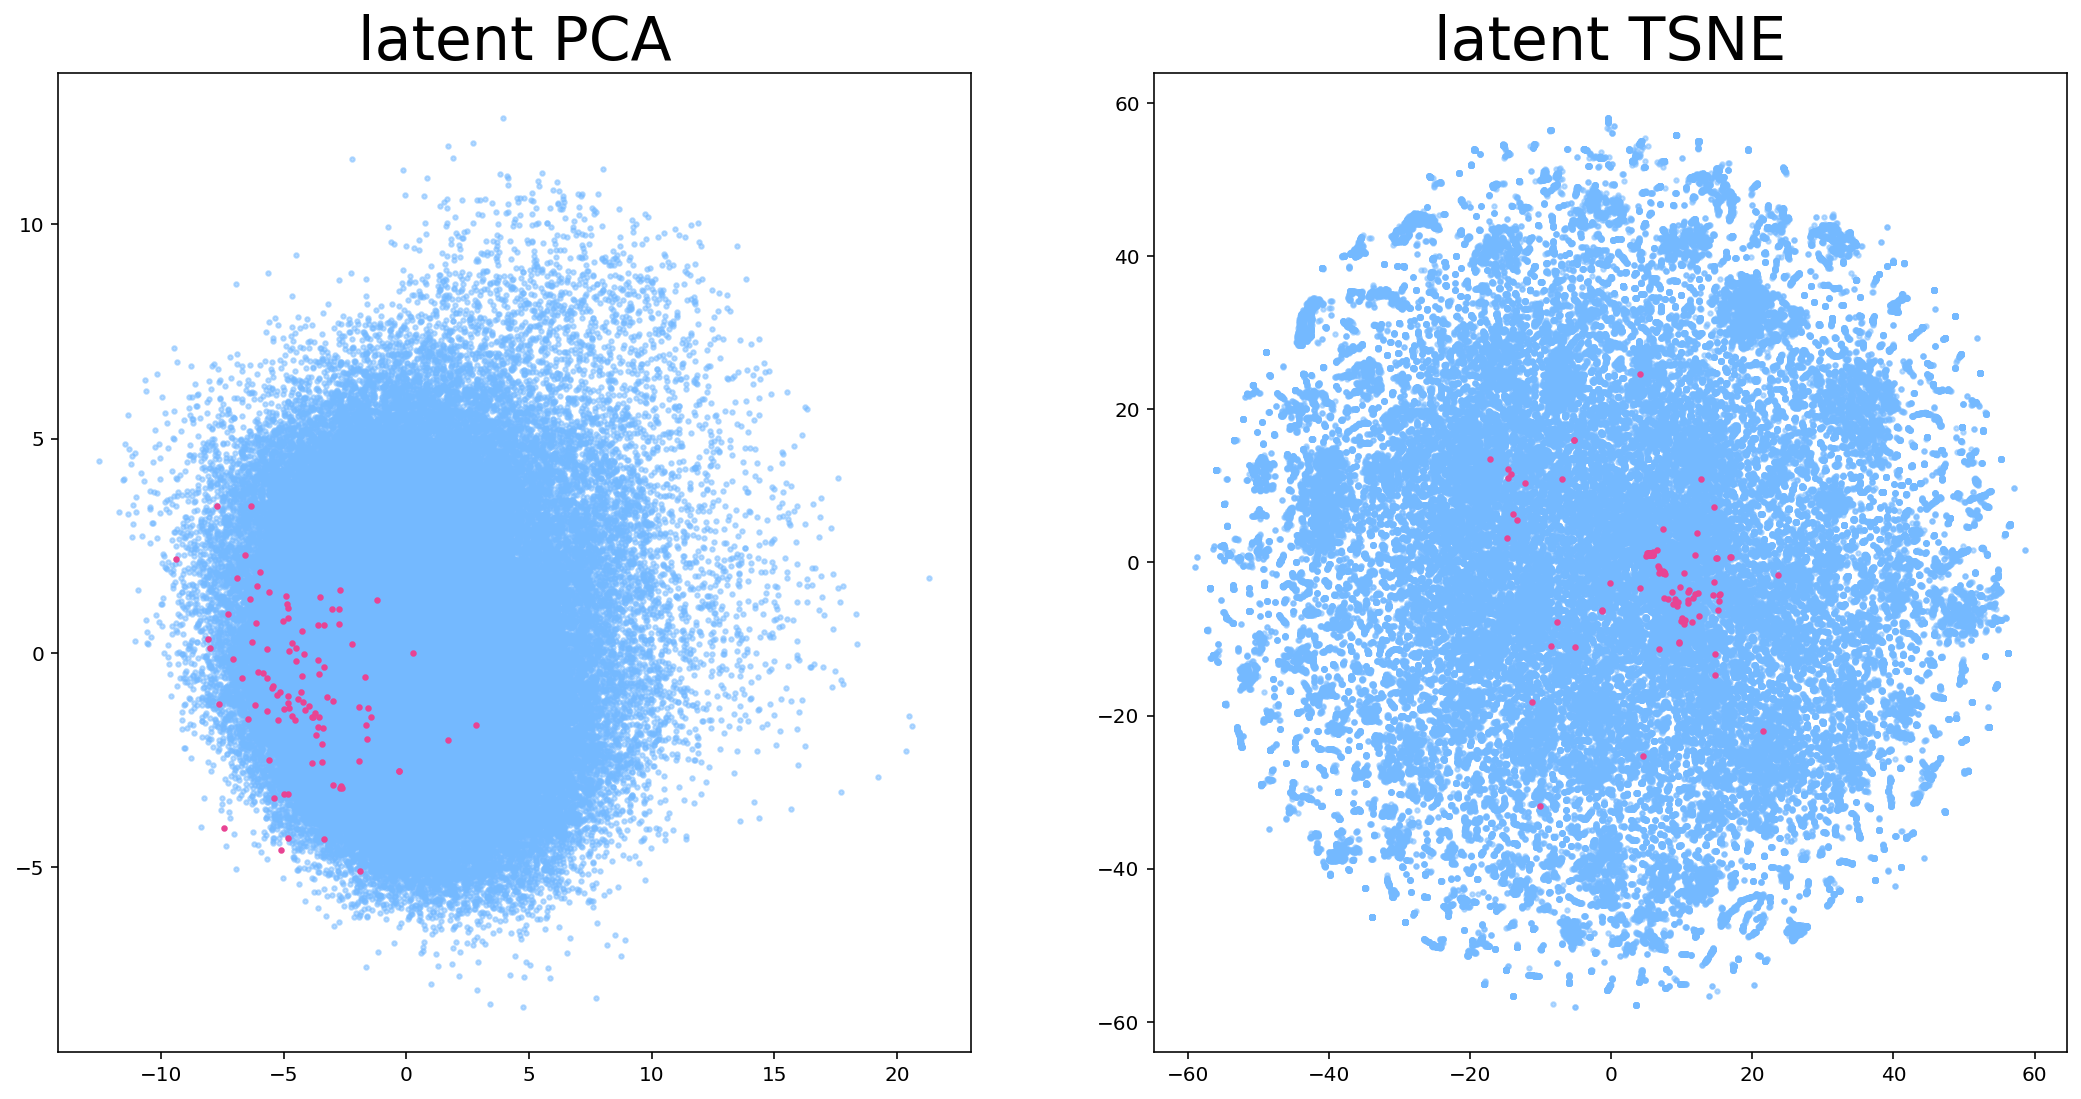

In [9]:
x1 = [ point[0] for point in points_latent_pca ]
y1 = [ point[1] for point in points_latent_pca ]

x2 = [ point[0] for point in points_latent_tsne ]
y2 = [ point[1] for point in points_latent_tsne ]

count = 0
for t in latent_target_group[::-1]:
    if t == 1:
        count += 1
    else:
        break

alpha1 = 1.0 
alpha0 = 0.5
size1 = 5
size0 = 5
color1 = '#e84393'
color0 = '#74b9ff'
bg_color = '#ffffff' # '#CAD3C8'
fontsize = 30

cmap = plt.cm.get_cmap('cool', 2)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((18, 9))
plt.rcParams['axes.facecolor'] = bg_color

plt.subplot(121)
plt.scatter(x1[:-count], y1[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x1[-count:], y1[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('latent PCA', fontsize=fontsize)

plt.subplot(122)
plt.scatter(x2[:-count], y2[:-count], c=color0, s=size0, alpha=alpha0)
plt.scatter(x2[-count:], y2[-count:], c=color1, s=size1, alpha=alpha1)
plt.title('latent TSNE', fontsize=fontsize)

plt.show()